# 데이터 증강

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!unzip drive/MyDrive/Archive.zip

Archive:  drive/MyDrive/Archive.zip
replace __MACOSX/._-1? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._-1           
  inflating: -1/-1_2_masked.JPG      
  inflating: __MACOSX/-1/._-1_2_masked.JPG  
  inflating: -1/-1_1_masked.JPG      
  inflating: __MACOSX/-1/._-1_1_masked.JPG  
  inflating: -1/-1_3_masked.JPG      
  inflating: __MACOSX/-1/._-1_3_masked.JPG  
  inflating: __MACOSX/._-2           
  inflating: -2/-2_3_masked.JPG      
  inflating: __MACOSX/-2/._-2_3_masked.JPG  
  inflating: -2/-2_2_masked.JPG      
  inflating: __MACOSX/-2/._-2_2_masked.JPG  
  inflating: __MACOSX/._0            
  inflating: 0/0_1_masked.JPG        
  inflating: __MACOSX/0/._0_1_masked.JPG  
  inflating: 0/0_3_masked.JPG        
  inflating: __MACOSX/0/._0_3_masked.JPG  
  inflating: 0/0_2_masked.JPG        
  inflating: __MACOSX/0/._0_2_masked.JPG  
  inflating: __MACOSX/._1            
  inflating: 1/1_1_masked.JPG        
  inflating: __MACOSX/1/._1_1_masked.JPG  
  inflatin

In [32]:
import os

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

n_images = 75

In [2]:
def color_shift(image):
  image[image > 25] *= np.random.uniform(0.8, 1.2)
  image[image > 255] = 255
  return image.astype('int')

In [26]:
X = []
y = []

for label in os.listdir():
  if '.' in label: continue
  image_batch = []
  for item in os.listdir(label):
    if 'JPG' not in item.upper() or '1_masked' in item:  continue
    fig = cv2.imread(label + '/' + item)
    fig = cv2.cvtColor(fig, cv2.COLOR_BGR2GRAY)
    image_batch.append(fig.reshape(224, 224, 1))
  if len(image_batch) == 0: continue
  image_batch = np.array(image_batch)
  data_generator = ImageDataGenerator(
    horizontal_flip=True, vertical_flip=True, rotation_range=180,
    fill_mode='nearest', zoom_range=[0.75,1.25], preprocessing_function=color_shift
  )
  data_generator.fit(image_batch)

  data_gen_iter = data_generator.flow(image_batch)
  X.append(image_batch)
  y += [abs(int(label))] * image_batch.shape[0]

  for i in range(n_images):
    aug_image_batch = next(data_gen_iter)
    aug_image = aug_image_batch.reshape(-1, 224, 224, 1)
    aug_image = aug_image.astype('int')
    X.append(aug_image)
    y += [abs(int(label))] * aug_image.shape[0]

In [27]:
total = sum(item.shape[0] for item in X)
total

1216

In [28]:
for i in range(len(X)):
  cv2.imwrite(f'{y[i]}_{i}_masked.png', X[i])

In [29]:
images = np.empty((total, 224, 224, 1))
curr_idx = 0

for i in range(len(X)):
  images[curr_idx:curr_idx+X[i].shape[0]] = X[i]
  curr_idx += X[i].shape[0]

In [30]:
X = images
del images
X.shape

(1216, 224, 224, 1)

In [31]:
import gc
gc.collect()

8695

# CNN 모델 구성

In [32]:
import numpy as np

X = X/255
y = np.array(y)
print(X.shape, y.shape)

(1216, 224, 224, 1) (1216,)


In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [34]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=X.shape[1:]),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)     

In [35]:
import gc
gc.collect()

601

In [36]:
np.save('X.npy', X)
np.save('y.npy', y)

In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss='mse', metrics=['mae', 'mse'])

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
history = model.fit(X_train, y_train, epochs=128, batch_size=16, validation_data=[X_test, y_test], callbacks=[early_stopping, reduce_lr, model_checkpoint])

49/49 [==============================] - ETA: 0s - loss: 0.4166 - mae: 0.5220 - mse: 0.4166
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
49/49 [==============================] - 4s 80ms/step - loss: 0.4166 - mae: 0.5220 - mse: 0.4166 - val_loss: 11.7267 - val_mae: 2.8366 - val_mse: 11.7267 - lr: 1.0000e-06
Epoch 5/128
49/49 [==============================] - 4s 79ms/step - loss: 0.4197 - mae: 0.5239 - mse: 0.4197 - val_loss: 13.2402 - val_mae: 3.0440 - val_mse: 13.2402 - lr: 8.0000e-07
Epoch 6/128
49/49 [==============================] - 4s 80ms/step - loss: 0.3915 - mae: 0.5157 - mse: 0.3915 - val_loss: 13.8205 - val_mae: 3.1287 - val_mse: 13.8205 - lr: 8.0000e-07
Epoch 6: early stopping
Epoch 1/128
61/61 [==============================] - 9s 98ms/step - loss: 3.6411 - mae: 1.4784 - mse: 3.6411 - val_loss: 4.3396 - val_mae: 1.5949 - val_mse: 4.3396 - lr: 1.0000e-06
Epoch 2/128
61/61 [==============================] - 5s 75ms/step - loss: 1.0278 - mae: 0.

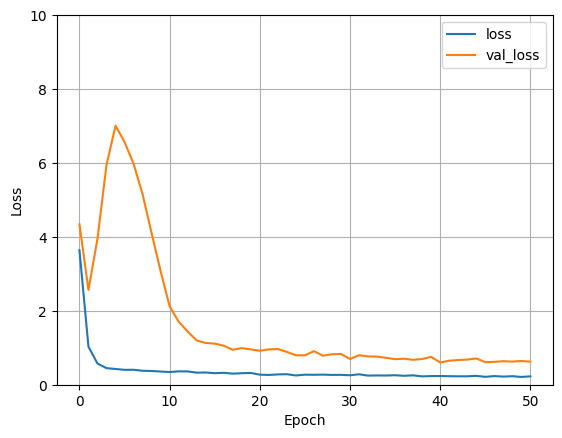

In [41]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
print(f'Predicted value: {np.round(model.predict(X_test[:10]).reshape(-1), 1)}')
print(f'Actual value: {y_test[:10]}')

1/1 [==============================] - 0s 101ms/step
Predicted value: [1.  3.8 1.8 2.3 0.7 4.7 2.  2.5 3.4 3.1]
Actual value: [0 3 1 2 0 5 1 2 3 3]


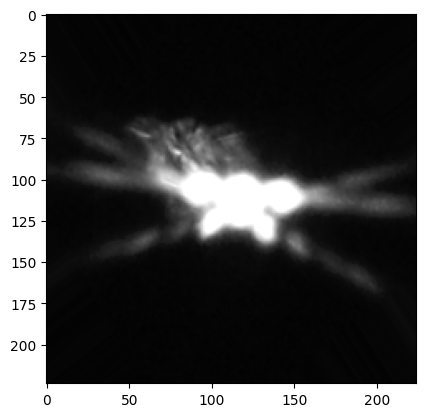

In [43]:
plt.imshow(X[6], cmap='gray')

In [44]:
import tensorflow as tf
import cv2
import numpy as np
model = tf.keras.models.load_model('/content/model.keras')

In [45]:
X_test, y_test = [], []

for i in range(-2, 6):
  for item in os.listdir(str(i)):
    if '1_masked' not in item: continue
    fig = cv2.imread(str(i) + '/' + item)
    fig = cv2.cvtColor(fig, cv2.COLOR_BGR2GRAY)
    fig = fig/255

    X_test.append(fig.reshape(224, 224, 1))
    y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

y_predict = model.predict(X_test)

1/1 [==============================] - 0s 106ms/step


In [46]:
from sklearn.metrics import r2_score

r2_score(y_test, y_predict) # 결정계수

0.5594827209130793

In [47]:
print(f'MAE: {np.abs(y_test - y_predict).mean()}\nMSE: {((y_test - y_predict) ** 2).mean()}\nRMSE: {(((y_test - y_predict) ** 2).mean())**0.5}\n')

MAE: 1.8417319764896316
MSE: 4.753600624657183
RMSE: 2.18027535523777

